In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results
from plotting.entropy_map_plots import plot_entropy_map_for_patient
from plotting.result_plots import plot_referral_results

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 1

# baseline: 
exp_base = {3: "20180509_18_36_23_dcnn_f3_150KE_lr2e02",
            2: "20180509_18_36_28_dcnn_f2_150KE_lr2e02",
            1: "20180509_18_36_32_dcnn_f1_150KE_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])

# 3: "20180628_15_28_44_dcnn_f3_150KE_lr2e02",
# 2: "20180628_15_18_08_dcnn_f2_150KE_lr2e02",
exp_base_brier = {3: "20180628_15_28_44_dcnn_f3_brier_150KE_lr2e02",
                  2: "20180628_15_18_08_dcnn_f2_brier_150KE_lr2e02",
                  1: "20180628_13_53_01_dcnn_f1_brier_150KE_lr2e02",
                  0: "20180628_13_51_59_dcnn_f0_brier_150KE_lr2e02"}

exp_base_brier_path = os.path.join(LOG_DIR, exp_base_brier[TEST_FOLD])


exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])


exp_mc01_softmax = {3: "20180630_10_26_32_dcnn_mc_f3p01_150KE_lr2e02",
                    2: "20180630_10_27_07_dcnn_mc_f2p01_150KE_lr2e02",
                    1: "20180629_11_28_29_dcnn_mc_f1p01_150KE_lr2e02",
                    0: "20180629_10_33_08_dcnn_mc_f0p01_150KE_lr2e02"}
exp_mc01_softmax_path = os.path.join(LOG_DIR, exp_mc01_softmax[TEST_FOLD])


In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_hdl_base = ExperimentHandler()
exper_hdl_base.load_experiment(exp_base_path, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("Base DCNN fold-{} (p={})".format(
                                     exper_hdl_base.exper.run_args.fold_ids[0],
                                     exper_hdl_base.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_base.model_name))
print("-------------------------------------------------------------------------")
exper_hdl_base_brier = ExperimentHandler()
exper_hdl_base_brier.load_experiment(exp_base_brier_path, use_logfile=False)
exper_hdl_base_brier.set_root_dir(ROOT_DIR)
exper_hdl_base_brier.set_model_name("Base DCNN fold-{} (p={})".format(
                                      exper_hdl_base_brier.exper.run_args.fold_ids[0],
                                      exper_hdl_base_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_base_brier.model_name))
print("-------------------------------------------------------------------------")
exper_hdl_mc01_brier = ExperimentHandler()
exper_hdl_mc01_brier.load_experiment(exp_mc01_brier_path, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_brier.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_softmax = ExperimentHandler()
exper_hdl_mc01_softmax.load_experiment(exp_mc01_softmax_path, use_logfile=False)
exper_hdl_mc01_softmax.set_root_dir(ROOT_DIR)
exper_hdl_mc01_softmax.set_model_name("MC-dropout softmax fold-{} (p={})".format(
                                exper_hdl_mc01_softmax.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_softmax.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_softmax.model_name))
print("-------------------------------------------------------------------------")

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 1
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180509_18_36_32_dcnn_f1_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn p=0.50 fold=1 loss=softdice
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180628_13_53_01_dcnn_f1_brier_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn p=0.50 fold=1 loss=brier
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=1 loss=brier
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180629_11_28_29_dcnn_mc_f1p01_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=1 loss=softdice
-------------------------------

In [5]:
referral_thresholds = [0.001, 0.01, 0.08, 0.1]

ref_res_base_ep = ReferralResults(exp_base, referral_thresholds, print_results=False,
                                  fold=None, slice_filter_type=None, use_entropy_maps=True)

ref_res_basebrier_ep = ReferralResults(exp_base_brier, referral_thresholds, print_results=False,
                                       fold=None, slice_filter_type=None, use_entropy_maps=True)

ref_res_mcbrier_ep = ReferralResults(exp_mc01_brier, referral_thresholds, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=True)


ref_res_mcsoftmax_ep = ReferralResults(exp_mc01_softmax, referral_thresholds, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=True)

INFO - Loading referral results for thresholds [0.001, 0.01, 0.08, 0.1]
WARNING - referral positives-only=False
INFO - Loading referral results for thresholds [0.001, 0.01, 0.08, 0.1]
WARNING - referral positives-only=False
INFO - Loading referral results for thresholds [0.001, 0.01, 0.08, 0.1]
WARNING - referral positives-only=False
INFO - Loading referral results for thresholds [0.001, 0.01, 0.08, 0.1]
WARNING - referral positives-only=False


In [36]:

referral_thresholds = [0.001, 0.01, 0.08]
ref_res_mcbrier_ep = ReferralResults(exp_mc01_brier, referral_thresholds, print_results=False,
                              fold=0, slice_filter_type=None, use_entropy_maps=True)

referral_thresholds = [0.08, 0.1]
ref_res_mcbrier_umap = ReferralResults(exp_mc01_brier, referral_thresholds, print_results=False,
                              fold=0, slice_filter_type=None, use_entropy_maps=False)

WARNING - only loading results for fold 0
INFO - Loading referral results for thresholds [0.001, 0.01, 0.08]
WARNING - referral positives-only=False
WARNING - only loading results for fold 0
INFO - Loading referral results for thresholds [0.08, 0.1]
WARNING - referral positives-only=False


INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/dcnn_mc_p01_f0_brier_referral_results_allslices_ent_maps.pdf


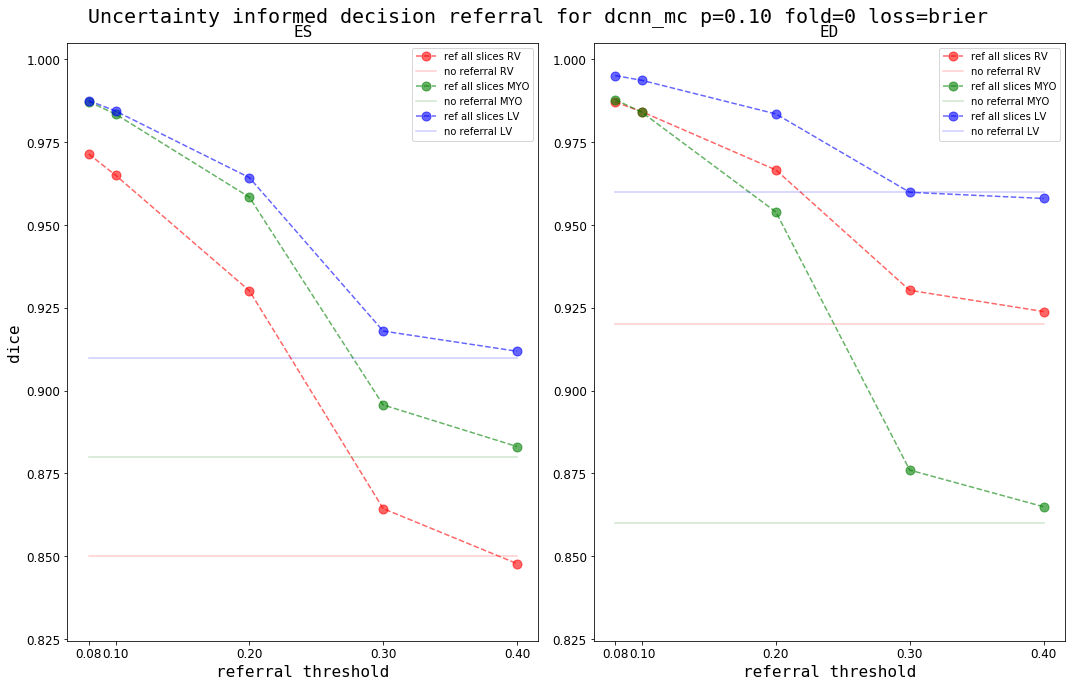

In [10]:
from plotting.result_plots import plot_referral_results

# model_name = "DCNN-MC (p=0.1)"
exper_handler = exper_hdl_mc01_brier   # exper_hdl_mc01_brier
model_name = exper_handler.model_name # .model_name
fig_name = "{}_p{}_f{}_{}".format(exper_handler.exper.run_args.model,
                                             str(exper_handler.exper.run_args.drop_prob).replace(".", ""),
                                             exper_handler.exper.run_args.fold_ids[0],
                                             exper_handler.exper.run_args.loss_function)
plot_referral_results(ref_results_entropy, ref_slice_results=None, #ref_slice_results, 
                     # ref_random_obj=ref_random_slice_results,
                      width=16 , height=16, do_save=True, model_name=model_name, fig_name=fig_name)

In [23]:
from plotting.referral_stats_plots import show_referral_results

# ref_res_base_ep
# ref_res_basebrier_ep
# ref_res_mcbrier_ep
# ref_res_mcsoftmax_ep
#  MC-brier:     0.85/0.88/0.91	ED 0.92/0.86/0.96
#  MC-soft:      0.83/0.86/0.90	ED 0.91/0.85/0.95
#  base:soft: ES 0.83/0.87/0.91	ED 0.92/0.85/0.96
show_referral_results(ref_res_base_ep, referral_threshold=0.1, per_disease=False, print_latex_string=True)

----------------------Overall results for referral-threshold 0.10 ----------------------
without referral - dice(RV/Myo/LV):	ES 0.83/0.87/0.91	ED 0.92/0.85/0.96
without referral - HD (RV/Myo/LV):	ES 15.87/11.68/8.98	ED 15.45/12.68/8.18
   with referral - dice(RV/Myo/LV):	ES 0.91/0.93/0.95	ED 0.95/0.92/0.97
   with referral - HD (RV/Myo/LV):	ES 10.69/8.95/7.00	ED 11.26/9.18/6.35
----------------------------------------------------------------------------------------------
INFO - Latex strings
Dice coefficients with referral
 & 0.91 & 0.93  & 0.95 & 0.95 & 0.92 & 0.97 



In [39]:
show_referral_results(ref_res_mcbrier_umap, referral_threshold=0.1, per_disease=True)

----------------------Overall results for referral-threshold 0.10 ----------------------
without referral - dice(RV/Myo/LV):	ES 0.87/0.89/0.92	ED 0.94/0.88/0.96
without referral - HD (RV/Myo/LV):	ES 14.38/11.16/8.76	ED 11.57/9.76/6.45
   with referral - dice(RV/Myo/LV):	ES 0.99/0.99/0.99	ED 1.00/0.99/1.00
   with referral - HD (RV/Myo/LV):	ES 4.25/3.96/2.78	ED 3.03/2.98/2.61

------------------------------ Results for class NOR ----------------------------------
ES & ED Mean/median u-value 0.00/0.00 & 0.00/0.00	 % slices referred 0.00 & 0.00
without referral - dice(RV/Myo/LV):	ES 0.88/0.91/0.93	ED 0.96/0.90/0.97
   with referral - dice(RV/Myo/LV):	ES 0.99/1.00/1.00	ED 1.00/0.99/0.99
without referral - HD (RV/Myo/LV):	ES 12.77/8.00/7.91	ED 7.12/8.16/5.84
   with referral - HD (RV/Myo/LV):	ES 4.75/2.19/1.80	ED 3.26/4.75/3.52
 
------------------------------ Results for class DCM ----------------------------------
ES & ED Mean/median u-value 0.00/0.00 & 0.00/0.00	 % slices referred 0.00 &

In [29]:
exper_hdl_base.create_entropy_maps(do_save=True)

INFO - Saved all entropy maps to /home/jorg/repository/dcnn_acdc/logs/20180509_18_36_23_dcnn_f3_150KE_lr2e02/u_maps


In [12]:
exper_hdl_base.get_entropy_maps()

  4%|▍         | 1/25 [00:00<00:02,  9.12it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00, 11.34it/s]


INFO - Successfully loaded 25 ED/ES patient pairs
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180509_18_36_23_dcnn_f3_150KE_lr2e02/figures/patient002/patient002_entropy_map.pdf


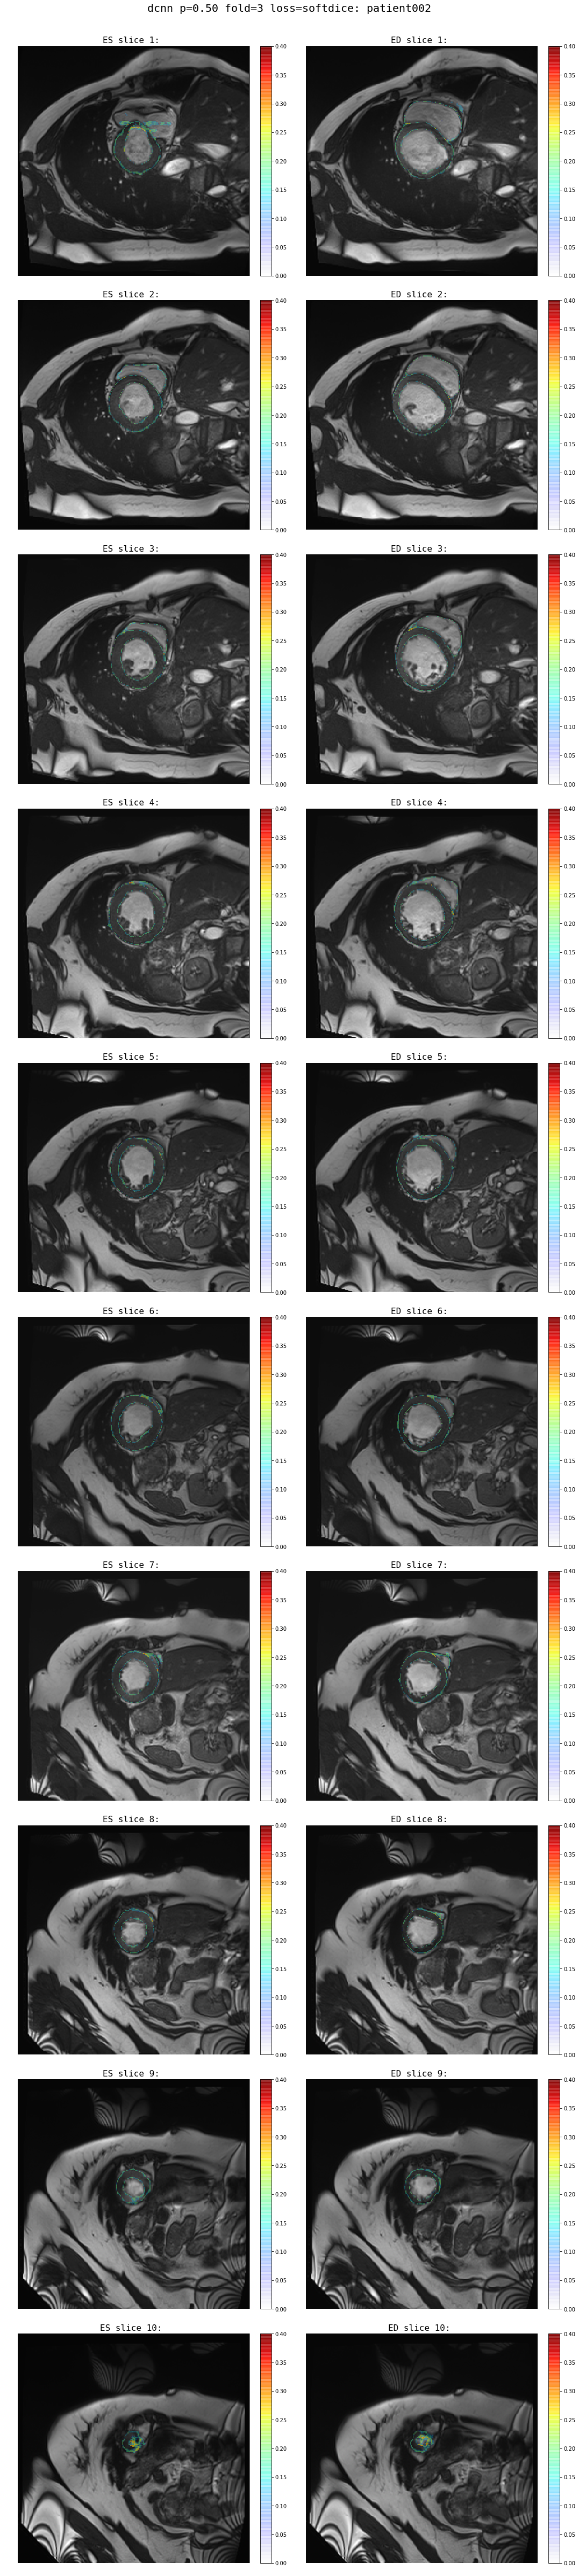

In [31]:
exper_handler = exper_hdl_base  # exper_hdl_base  exper_hdl_mc01_brier  exper_hdl_base_brier
patient_id = "patient002"
# "patient100"

plot_entropy_map_for_patient(exper_handler, patient_id, do_save=True)

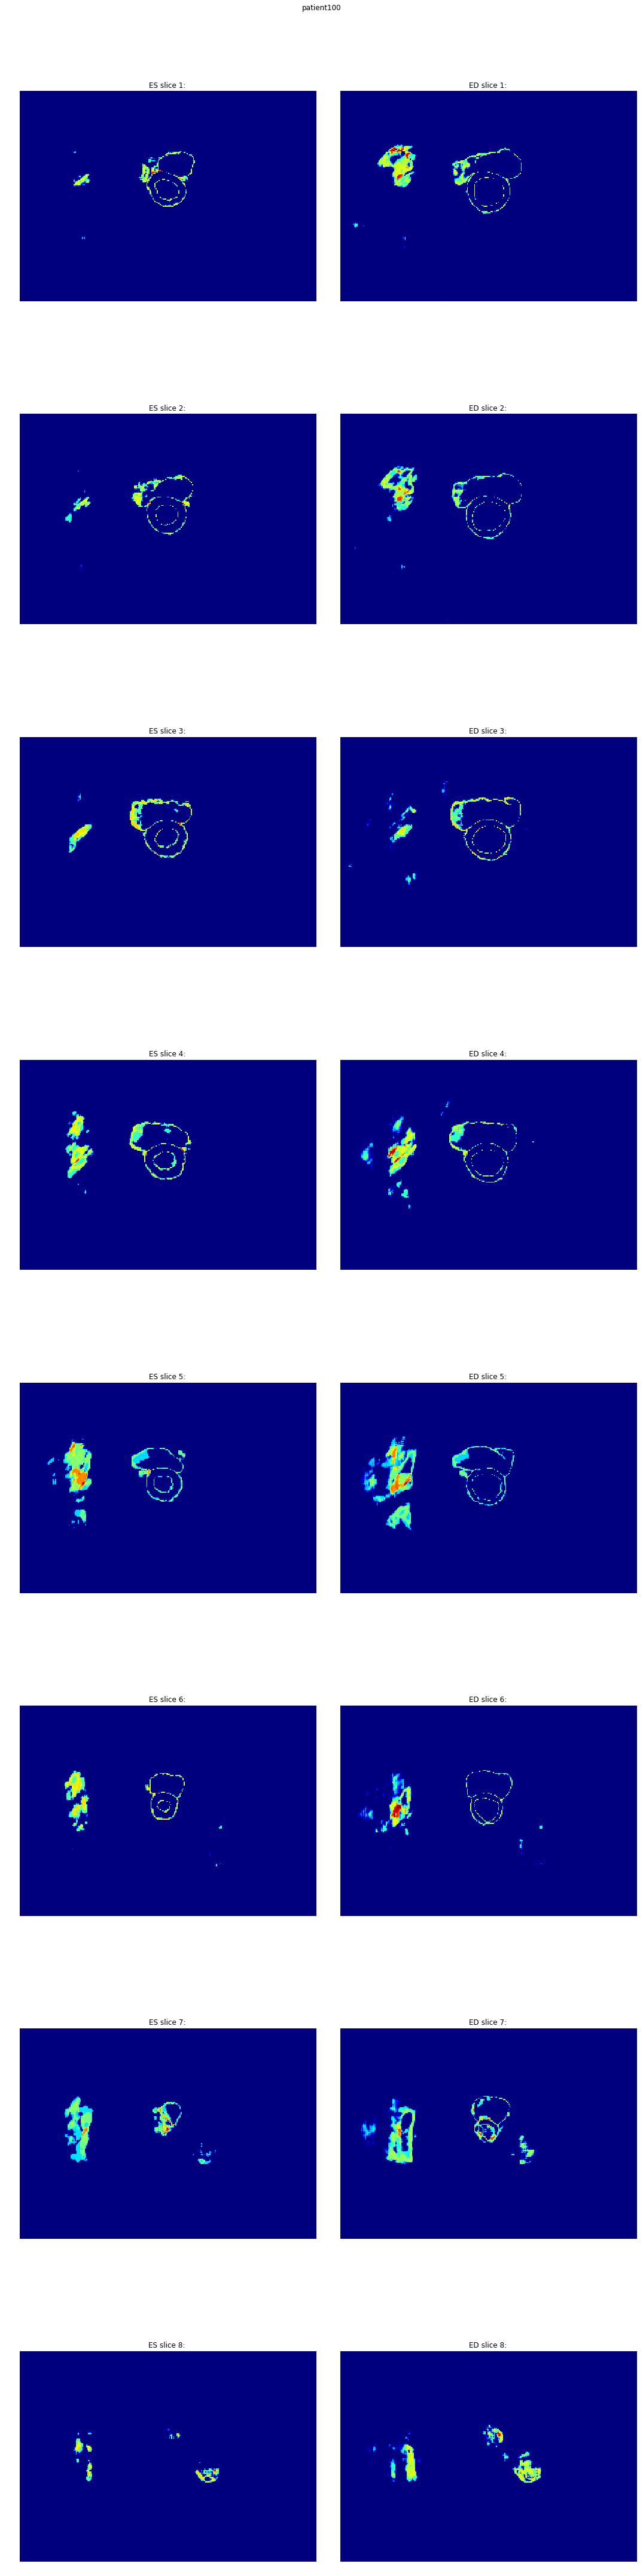

In [14]:
exper_handler = exper_hdl_base

patient_id = "patient100"
entropy_map = exper_handler.entropy_maps[patient_id]
num_of_slices = entropy_map.shape[3]
num_of_phases = 2
num_of_classes= 4

cls_labels = ["BG", "RV", "MYO", "LV"]
phase_labels = ["ES", "ED"]

slice_range = np.arange(num_of_slices)

rows = 2 *  num_of_slices
columns = 4
width = 16
height = 16 * num_of_slices / 2   # num_of_classes * 2 * num_of_slices

row = 0
column = 0

fig = plt.figure(figsize=(width, height))
fig.suptitle("{}".format(patient_id))
for slice_id in slice_range:
    for phase in np.arange(2):
        cls_offset = phase * num_of_classes
        column = 0
        entropy_slice_map = entropy_map[phase, :, :, slice_id]
        # print("Min/max values {:.2f}/{:.2f}".format(np.min(entropy_slice_map),
        #                                            np.max(entropy_slice_map)))
        ax1 = plt.subplot2grid((rows, columns), (row, phase * 2), rowspan=2, colspan=2)
        ax1plot = ax1.imshow(entropy_slice_map, cmap="jet",
                                       vmin=0.)

        plt.axis("off")
        ax1.set_title("{} slice {}: ".format(phase_labels[phase], slice_id+1))
        
    row += 2

fig.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])

(2, 203, 286, 8)
(2, 203, 286, 8)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/patient100_prob_entropy_dcnn_brier.jpeg


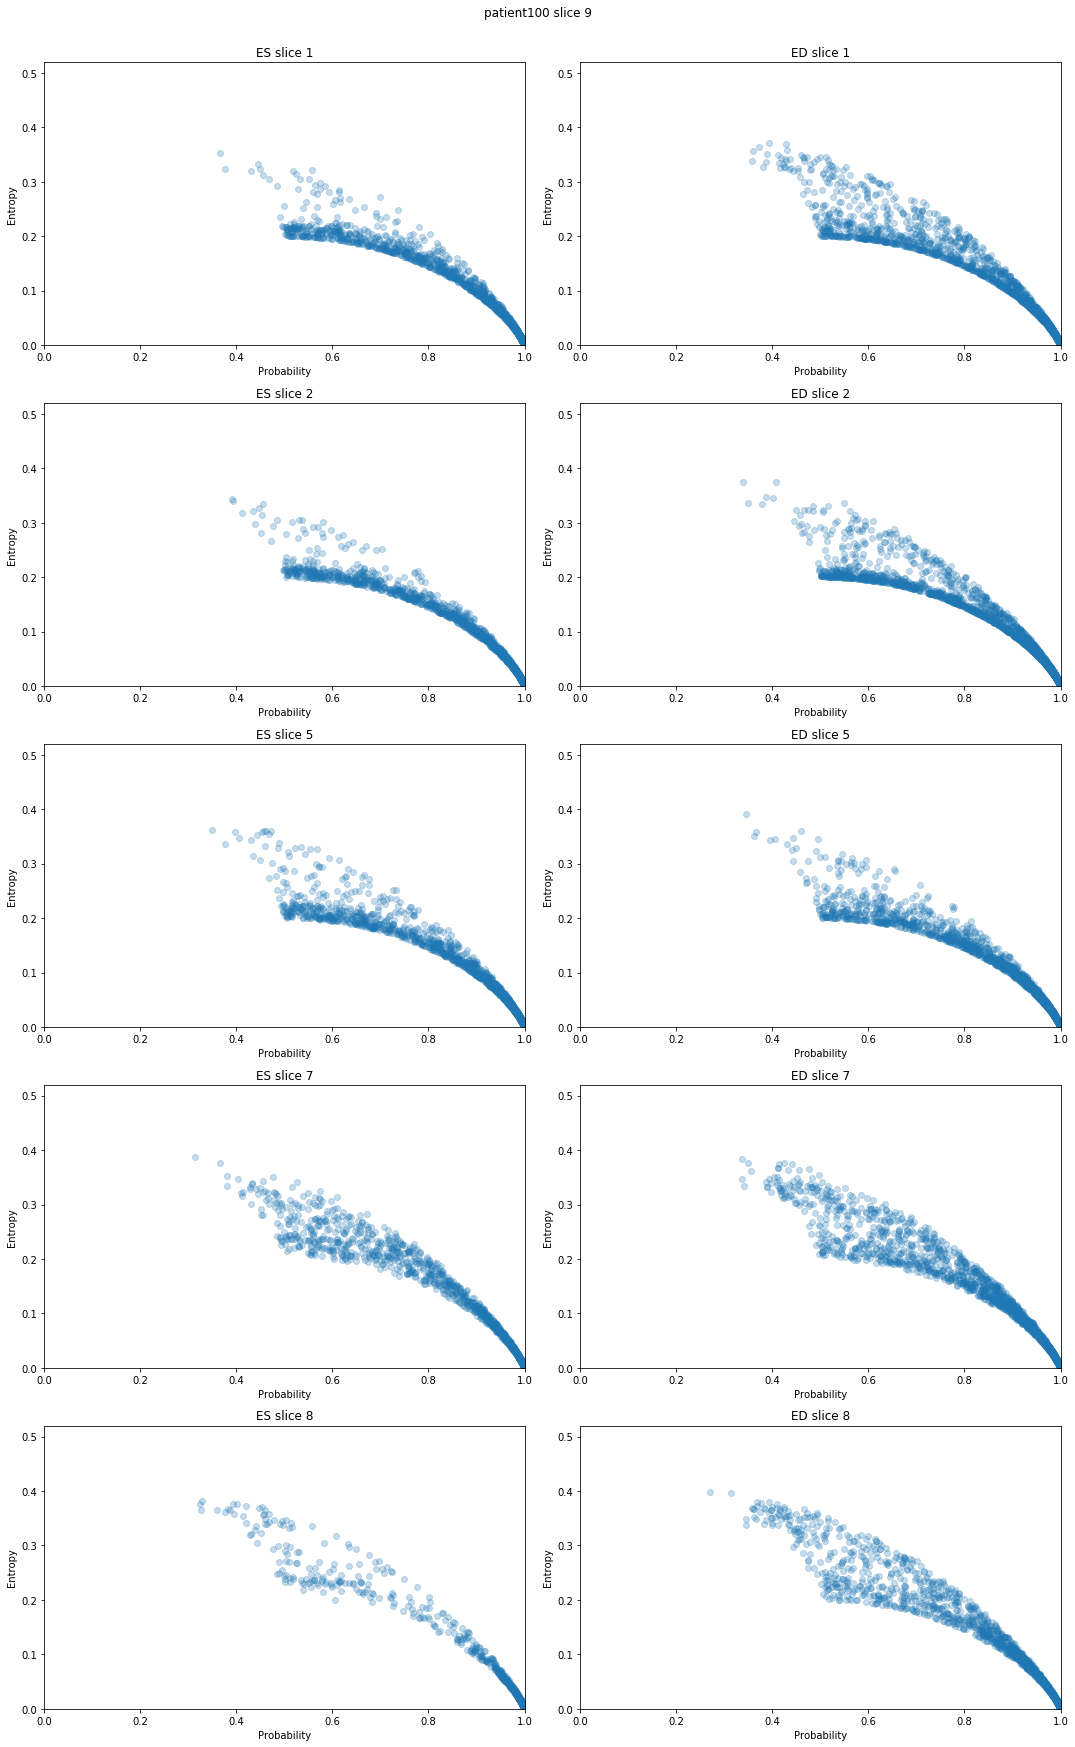

In [91]:
model = "dcnn_mc_brier"
model = "dcnn_softdice"
model = "dcnn_brier"
root_dir = "/home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/"
root_dir = "/home/jorg/repository/dcnn_acdc/logs/20180330_09_56_39_dcnnv1_150000E_lr2e02/"
root_dir = "/home/jorg/repository/dcnn_acdc/logs/20180628_13_51_59_dcnn_f0_150KE_lr2e02/"

indir1 = root_dir + "pred_lbls/"
indir2 = root_dir + "u_maps/"
indir3 = root_dir + "stats/"

patient_id = "patient100"  # patient017  patient079   patient100  
# org_slice_dice [2, 4, #slices]

umap_fname = patient_id + "_entropy_map.npz"

prob_fname = patient_id + "_pred_probs.npz"

prob_fname = os.path.join(indir1, prob_fname)
umap_fname = os.path.join(indir2, umap_fname)

data_prob = np.load(prob_fname)
data_umap = np.load(umap_fname)
pred_probs = data_prob["pred_probs"]
raw_umap = data_umap["entropy_map"]
mean_pred_probs = np.zeros((2, pred_probs.shape[1], pred_probs.shape[2], pred_probs.shape[3]))
mean_pred_probs[0] = np.max(pred_probs[:4], axis=0)
mean_pred_probs[1] = np.max(pred_probs[4:], axis=0)

print(mean_pred_probs.shape)
print(raw_umap.shape)
num_of_slices = pred_probs.shape[3]
num_of_phases = raw_umap.shape[0]
num_of_classes= 4

rows = num_of_slices * 2
columns = 4
width = 16
height = 20 * 2   # num_of_classes * 2 * num_of_slices

phase_labels = ["ES", "ED"]

slice_range = [0, 1, num_of_slices / 2, num_of_slices-2, num_of_slices-1]

row, column = 0, 0
fig = plt.figure(figsize=(width, height))
fig.suptitle("{} slice {}".format(patient_id, slice_id+1))

for slice_id in slice_range:
    column = 0
    for phase in np.arange(2):
        probs_slice_cls = mean_pred_probs[phase, :, :, slice_id].flatten()
        uvalues_slice_cls = raw_umap[phase, :, :, slice_id].flatten()

        ax1 = plt.subplot2grid((rows, columns), (row, column), rowspan=2, colspan=2)
        ax1.scatter(probs_slice_cls, uvalues_slice_cls, marker='o', alpha=0.25 )
        ax1.set_xlim([0, 1.])
        ax1.set_ylim([0., 0.52])
        ax1.set_xlabel("Probability")
        ax1.set_ylabel("Entropy")
        ax1.set_title("{} slice {}".format(phase_labels[phase], slice_id+1))
        if phase == 0:
            column = 2

    row += 2

fig.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])
fig_path = os.path.join(config.root_dir, "figures")
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)
fig_name = patient_id + "_prob_entropy_" + model
fig_name = os.path.join(fig_path, fig_name + ".jpeg")
plt.savefig(fig_name, bbox_inches='tight')
print("INFO - Successfully saved fig %s" % fig_name)
plt.show()
plt.close()

(2, 203, 286, 8)
(2, 203, 286, 8)


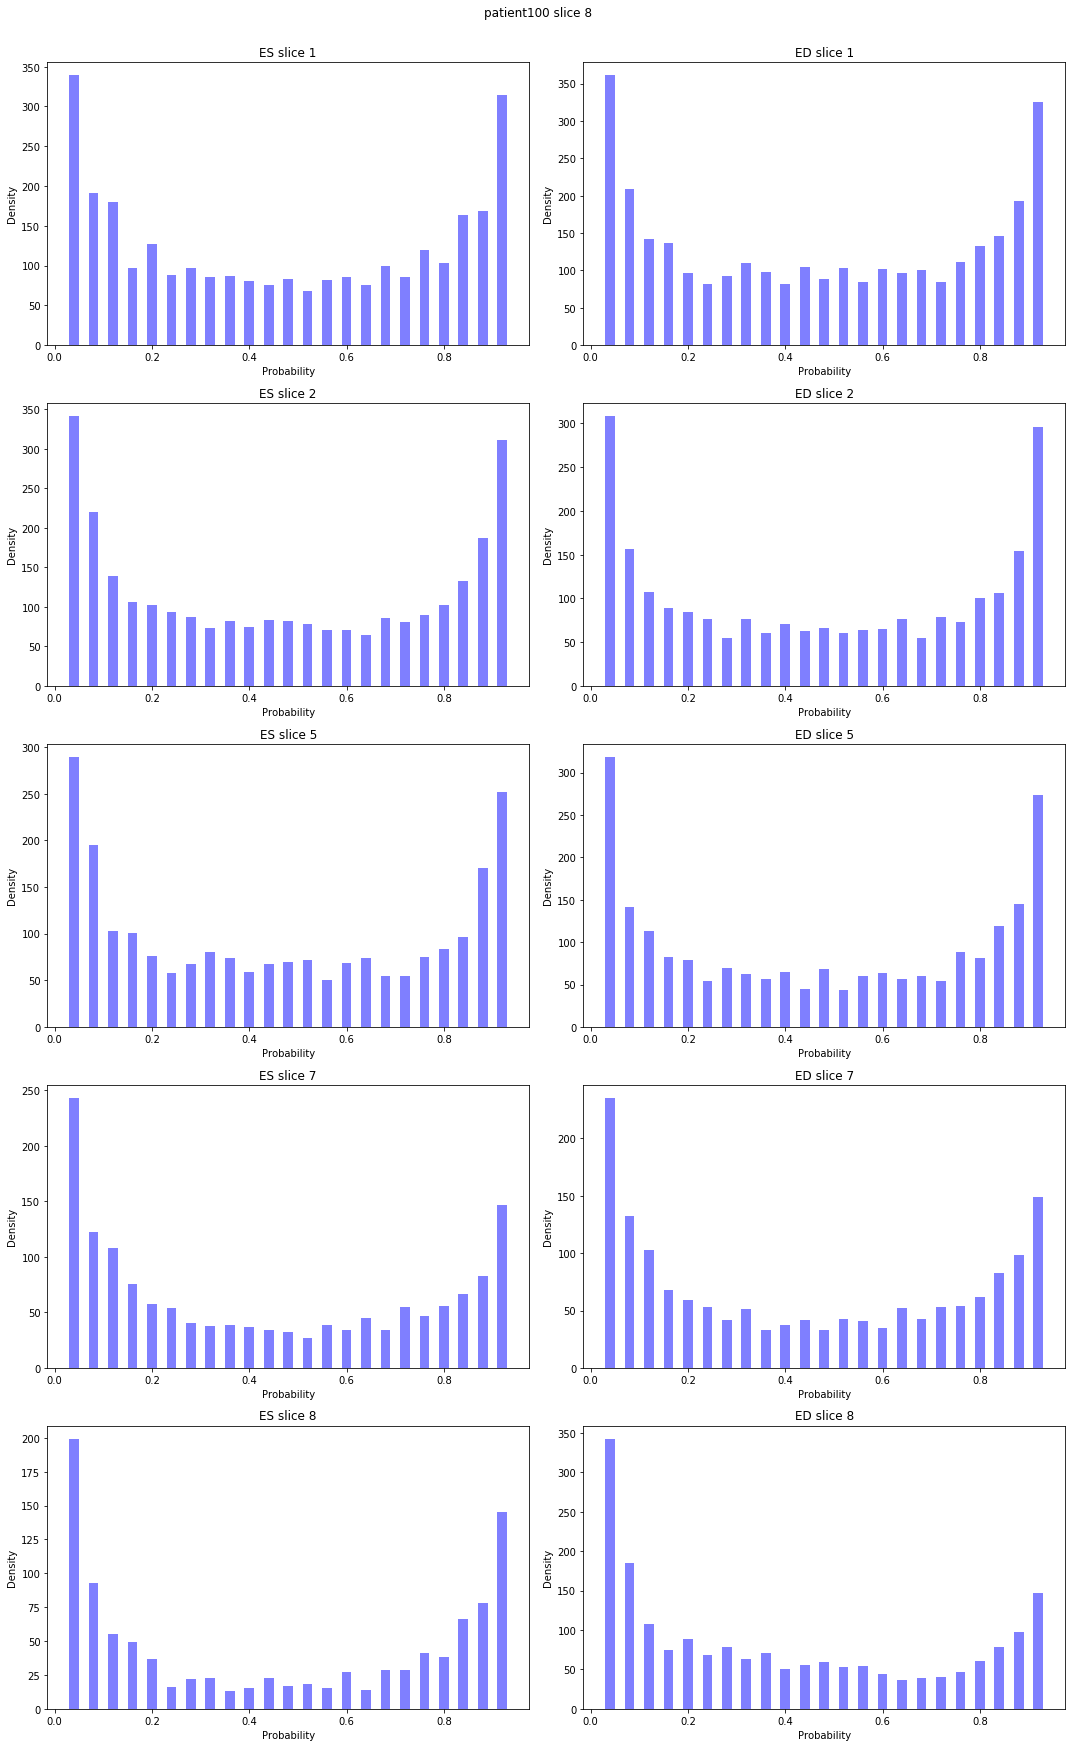

In [121]:
model = "dcnn_mc_brier"
model = "dcnn_softdice"
model = "dcnn_brier"
root_dir = "/home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/"
# root_dir = "/home/jorg/repository/dcnn_acdc/logs/20180330_09_56_39_dcnnv1_150000E_lr2e02/"
# root_dir = "/home/jorg/repository/dcnn_acdc/logs/20180628_13_51_59_dcnn_f0_150KE_lr2e02/"

indir1 = root_dir + "pred_lbls/"
indir2 = root_dir + "u_maps/"
indir3 = root_dir + "stats/"

patient_id = "patient100"  # patient017  patient079   patient100  
# org_slice_dice [2, 4, #slices]

umap_fname = patient_id + "_entropy_map.npz"

prob_fname = patient_id + "_pred_probs.npz"

prob_fname = os.path.join(indir1, prob_fname)
umap_fname = os.path.join(indir2, umap_fname)

data_prob = np.load(prob_fname)
data_umap = np.load(umap_fname)
pred_probs = data_prob["pred_probs"]
raw_umap = data_umap["entropy_map"]
phase_pred_probs = np.zeros((2, 4 * pred_probs.shape[1] *pred_probs.shape[2], pred_probs.shape[3]))
phase_pred_probs[0] = np.reshape(pred_probs[:4], (4 * pred_probs.shape[1] *pred_probs.shape[2], pred_probs.shape[3]))
phase_pred_probs[1] = np.reshape(pred_probs[4:], (4 * pred_probs.shape[1] *pred_probs.shape[2], pred_probs.shape[3]))

print(mean_pred_probs.shape)
print(raw_umap.shape)
num_of_slices = pred_probs.shape[3]
num_of_phases = raw_umap.shape[0]
num_of_classes= 4

rows = num_of_slices * 2
columns = 4
width = 16
height = 20 * 2   # num_of_classes * 2 * num_of_slices
num_of_bins = 25
phase_labels = ["ES", "ED"]

slice_range = [0, 1, num_of_slices / 2, num_of_slices-2, num_of_slices-1]

row, column = 0, 0
fig = plt.figure(figsize=(width, height))
fig.suptitle("{} slice {}".format(patient_id, slice_id+1))
bins = np.linspace(0, 1, num_of_bins + 1)
bar_width = 0.02

for slice_id in slice_range:
    column = 0
    for phase in np.arange(2):
        probs_slice_cls = phase_pred_probs[phase, :, slice_id].flatten()
        uvalues_slice_cls = raw_umap[phase, :, :, slice_id].flatten()
        yvalues, bin_edges = np.histogram(probs_slice_cls, num_of_bins)
        ax1 = plt.subplot2grid((rows, columns), (row, column), rowspan=2, colspan=2)

        ax1.bar(bin_edges[1:-2], yvalues[1:-1], bar_width, facecolor="blue", alpha=0.5, align="center")
        # ax1.set_xlim([0, 1.])
        # ax1.set_ylim([0., 0.52])
        ax1.set_xlabel("Probability")
        ax1.set_ylabel("Density")
        ax1.set_title("{} slice {}".format(phase_labels[phase], slice_id+1))
        if phase == 0:
            column = 2

    row += 2

fig.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])
fig_path = os.path.join(config.root_dir, "figures")
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)
fig_name = patient_id + "_prob_histogram_" + model
fig_name = os.path.join(fig_path, fig_name + ".jpeg")
# plt.savefig(fig_name, bbox_inches='tight')
# print("INFO - Successfully saved fig %s" % fig_name)
plt.show()
plt.close()